In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import frame as fr
from scipy.fft import fft, fftn, fftfreq, fftshift
%run range_doppler.ipynb


In [2]:
data = pd.read_csv('../../data/Conference_data/driving_diagonal_1.txt', sep='\t', header=None)
data.columns = ["idx","I_RX1","Q_RX1"]

In [3]:
SAMPLES_PER_CHIRP = 64
CHIRPS_PER_FRAME = 128
FRAME_NUMBER = len(data)//(SAMPLES_PER_CHIRP*CHIRPS_PER_FRAME)
T = 300e-6
SPEED_OF_LIGHT = 3e8
START_FREQUENCY = 24.025e9
B = 200e6
PULSE_REPETITION_INTERVAL = 500e-6
SAMPLE_PERIOD = T/SAMPLES_PER_CHIRP
SAMPLE_FREQUENCY = 1/SAMPLE_PERIOD
LAMBDA = SPEED_OF_LIGHT/START_FREQUENCY
RANGE_PAD = 256
DOPPLER_PAD = 256
FRAME_PERIOD = 0.1 #seconds

In [4]:
recording = data.select_dtypes(include = ['float']).values
ANTENNA_NUMBER = len(recording[0,:])//2

In [5]:
Hu_bi_frame = []
for frame in range(FRAME_NUMBER):
    Hu_bi_frame.append(fr.Frame(recording[frame*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(frame+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                           SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T))
    

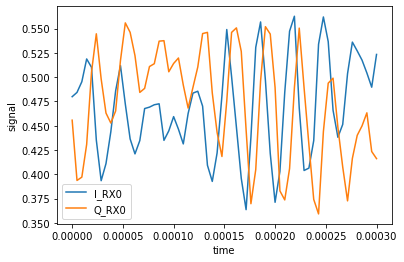

In [6]:
Hu_bi_frame[15].plot_chirp(0)

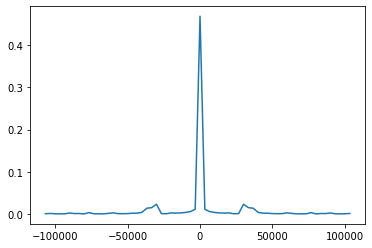

In [7]:
xf = fftfreq(SAMPLES_PER_CHIRP,T/SAMPLES_PER_CHIRP)
xf = fftshift(xf)
yf = fftn(np.real(Hu_bi_frame[15].get_chirp(0)),axes=0)/len(xf)
yplot = fftshift(yf)
plt.plot(xf, np.abs(yplot))
plt.show()

In [8]:
calibration_data = pd.read_csv('../../data/Conference_data/environment_1.txt', sep='\t', header=None)
calibration = calibration_data.select_dtypes(include = ['float']).values
calibration_frame = fr.Frame(calibration[0*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP:(0+1)*CHIRPS_PER_FRAME*SAMPLES_PER_CHIRP,:],\
                           SAMPLES_PER_CHIRP, CHIRPS_PER_FRAME, ANTENNA_NUMBER, T)

<function matplotlib.pyplot.show(close=None, block=None)>

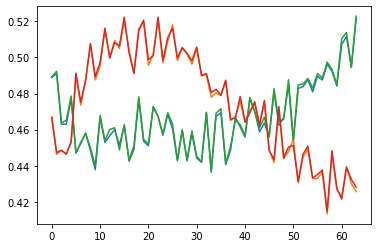

In [9]:
average_calib_chirp = np.zeros((SAMPLES_PER_CHIRP,ANTENNA_NUMBER),dtype=complex)
for chirp in range(CHIRPS_PER_FRAME):
    average_calib_chirp += calibration_frame.get_chirp(chirp)
average_calib_chirp /= CHIRPS_PER_FRAME
#averaged
plt.plot(np.real(average_calib_chirp))
plt.plot(np.imag(average_calib_chirp))
#non averaged
plt.plot(np.real(calibration_frame.chirp[:,:,0]))
plt.plot(np.imag(calibration_frame.chirp[:,:,0]))
plt.show

In [10]:
for frame in range(FRAME_NUMBER):
    Hu_bi_frame[frame].calibrate(average_calib_chirp)

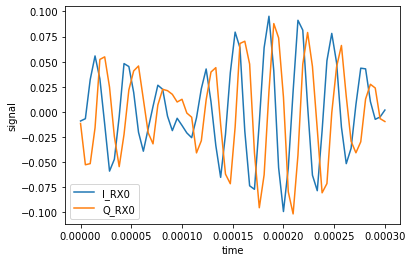

In [11]:
Hu_bi_frame[15].plot_chirp(0)

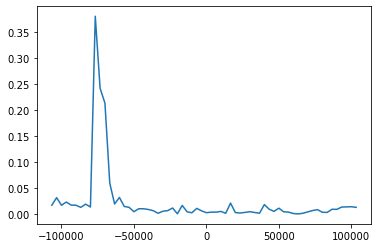

In [12]:
yf = fftn(Hu_bi_frame[15].get_chirp(0),axes=0)/np.sqrt(len(Hu_bi_frame[15].get_chirp(0)))
yplot = yf
plt.plot(xf, np.abs(yplot))
plt.show()

In [13]:
range2bin = 1/(T/SAMPLES_PER_CHIRP)/RANGE_PAD*T*SPEED_OF_LIGHT/(2*B)
FRAME_REP_INTERVAL = 0.2

In [14]:
#Plotting routine
xf = np.arange(0,RANGE_PAD)#fftfreq(RANGE_PAD,T/SAMPLES_PER_CHIRP)
range_bin = xf*T*SPEED_OF_LIGHT/(2*B)/(T/SAMPLES_PER_CHIRP)/RANGE_PAD
xf = fftfreq(DOPPLER_PAD,PULSE_REPETITION_INTERVAL)
doppler_bin = fftshift(xf)*SPEED_OF_LIGHT/(2*START_FREQUENCY)
xv,yv = np.meshgrid(range_bin,doppler_bin)


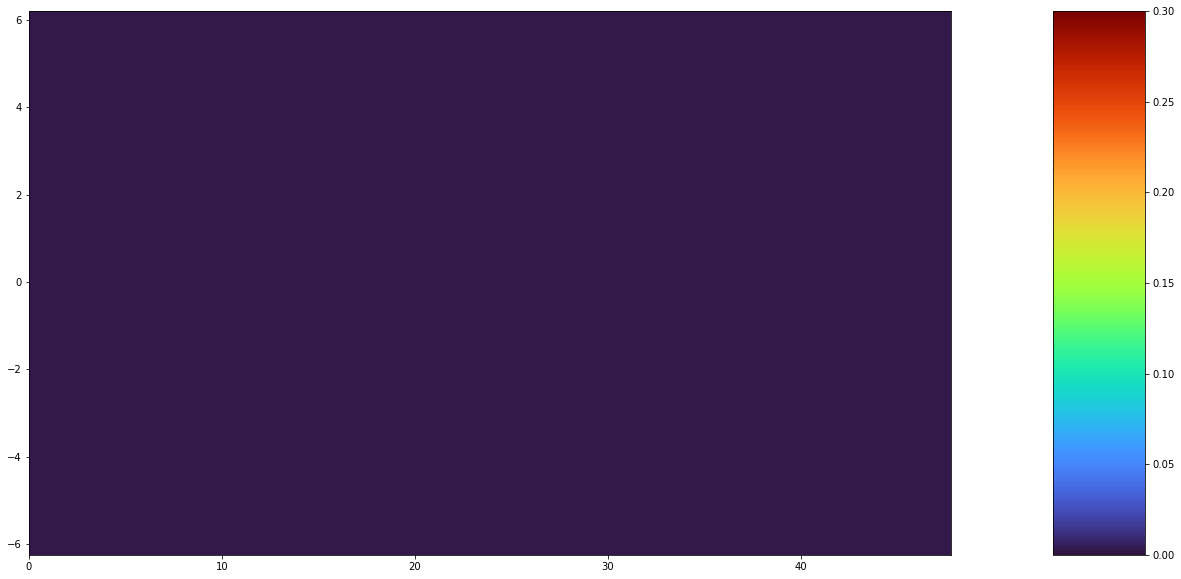

In [15]:

from matplotlib.animation import FuncAnimation, writers

#  
#plt.xlabel(r'x')
#plt.ylabel(r'y')
levels = np.linspace(0.0, 0.3, 50)

fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[10,1]},figsize=[20,10])
cmap = mpl.cm.get_cmap('turbo')
norm = mpl.colors.Normalize(vmin=0, vmax=.3)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
ax.set_xlim(min(range_bin), max(range_bin))
ax.set_ylim(min(doppler_bin), max(doppler_bin))


# animation function
def animate(i): 
    data_out = range_doppler_process(Hu_bi_frame[i],RANGE_PAD,DOPPLER_PAD)
    ax.clear()
    ax.contourf(xv,yv,np.abs(fftshift(data_out[:,0,:].T, axes=0)), levels, cmap=cmap, norm=norm)
    return ax  


anim = FuncAnimation(fig, animate, frames=FRAME_NUMBER)
Writer = writers['ffmpeg']
writer = Writer(fps=1/(FRAME_REP_INTERVAL), metadata={'artist':'Me'}, bitrate=3600)
anim.save('driving_diagonal_1.mp4',writer)

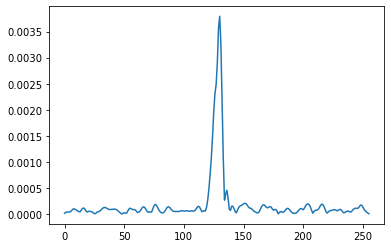

In [16]:
data_out = range_doppler_process(Hu_bi_frame[0],RANGE_PAD,DOPPLER_PAD)
plt.plot(np.abs(fftshift(data_out[0,0,:])))